In [1]:
%reload_ext autoreload
%autoreload 2

%run init_imports.py

from photutils.isophote import Ellipse
from photutils.isophote import EllipseGeometry
from photutils.aperture import EllipticalAperture
from photutils.isophote import build_ellipse_model
plt.rcParams['font.family'] = 'monospace'

In [2]:
galaxy_name = "UGC09629"
imageFile = f"../data/{galaxy_name}_i.fits"
maskFile = f"../data/{galaxy_name}_mask2D_new.fits"
data = pyimfit.FixImage(fits.getdata(imageFile))
shape = data.shape
print(shape)
data_mask = pyimfit.FixImage(fits.getdata(maskFile))  
fwhm, beta = 1.25136, 3.59000
data_moffat = pyimfit.moffat_psf(fwhm=fwhm, beta=beta, 
                PA=0.0, ell=0.0, size=31)
gain, sky, zcal, ron = 6.565, 221.61079, -23.59790, 5.76

(276, 231)
ModelObjectWrapper: about to call _model.CreateModelImage()...


Object  =I_recor.fits                                                            [astropy.io.fits.card]
Instrument =                                                                     [astropy.io.fits.card]
Input center =       111.09454       145.93892                                   [astropy.io.fits.card]
Best fit parameters                                                              [astropy.io.fits.card]
Ie(counts) =         690.93966                                                   [astropy.io.fits.card]
Re(arcsec) =         6.4766909                                                   [astropy.io.fits.card]
I0(counts) =          264.03936                                                  [astropy.io.fits.card]
h(arcsec) =       32.284417                                                      [astropy.io.fits.card]


In [3]:
x0, y0 = 111.0, 146.0
# Exp params
PA_exp, ell_exp, I_0, h = 38, 0.65, 497, 30.3575
# Sersic params
PA_sersic, ell_sersic, n, I_e, r_e = 18, 0.4, 1.35, 1061, 5.77

model_desc = ut.exp_sersic_model(
    x0=x0, y0=y0, 
    PA_sersic=PA_sersic, ell_sersic=ell_sersic, n=n, I_e=I_e, r_e=r_e,
    PA_exp=PA_exp, ell_exp=ell_exp, I_0=I_0, h=h
    )

imfit_fitter = pyimfit.Imfit(model_desc, psf=data_moffat)
imfit_fitter.fit(data, mask=data_mask, gain=gain, read_noise=ron, original_sky=sky)
data_fit = imfit_fitter.getModelImage()
data_res = data - data_fit

results = ut.get_dic_result(imfit_fitter, printit=True)

Parameter            Value                Error               
------------------------------------------------------------
X0_1                 111.98               0.0                 
Y0_1                 146.95               0.0                 
PA_1                 39.88                0.22                
ell_sersic_1         0.2                  0.0                 
n_1                  1.37                 0.01                
I_e_1                844.67               3.91                
r_e_1                5.85                 0.02                
PA_2                 28.73                0.06                
ell_exp_2            0.65                 0.0                 
I_0_2                311.7                1.77                
h_2                  29.73                0.1                 
chi^2                3.38                
AIC                  50886.79            
BIC                  50970.57            


In [4]:
data_mag = ut.ADU_to_mag(data, sky=sky, gain=gain, zcal=zcal)
data_fit_mag = ut.ADU_to_mag(data_fit, sky=sky, gain=gain, zcal=zcal)
data_res_mag = data_mag - data_fit_mag

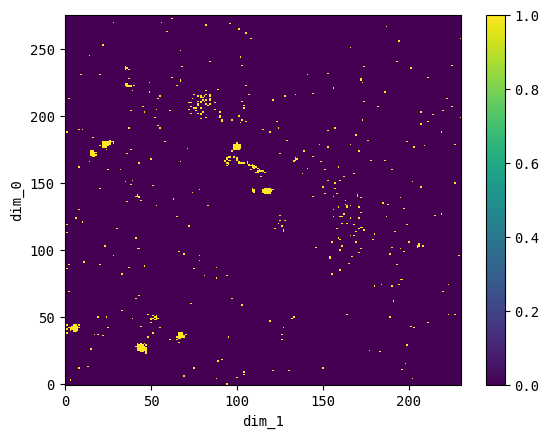

In [5]:
maskFile = f"../data/{galaxy_name}_mask2D_new.fits"
data_mask = pyimfit.FixImage(fits.getdata(maskFile))  

resmag_xr = xr.DataArray(data_res_mag)

#compute 90th percentile
p = 0.01
thres = resmag_xr.quantile(p).values

masked = xr.where(resmag_xr < thres, resmag_xr, 0)
masked = xr.where(resmag_xr >= thres, masked, 1)
masked.plot()
mask_val = masked.values
hdu = fits.PrimaryHDU(mask_val)

savefold = f'../data/'
savepath = f'{savefold}{galaxy_name}_own_mask.fits'

hdu.writeto(savepath, overwrite=True)

dims = ('y', 'x')
coords = {'y': np.arange(shape[0]), 'x': np.arange(shape[1])}
data_mask_xr = xr.DataArray(data_mask, dims=dims, coords=coords)
# data_mask_xr = 
data_mask_xr[140:210, 70:120] = 0
data_mask_mod = data_mask_xr.values